## Q1. Kernel PCA of matrices

We're going to show how using kernel functions we can apply standard learning algorithms, such as Principal Component Analysis (PCA) to mathematical objects other than vectors. We'll going to do PCA on matrices. Each one of our datapoints will be a matrix rather than a vector. Since we showed in Chapter 3 that we can PCA solely in terms of inner products, it means we can do PCA on a dataset of matrices provided we can define a kernel function that takes matrices as inputs. 

Doing PCA on a dataset of matrices can help us visualize that dataset because we can use the dimenionality reduction apsect of PCA and plot the dataset in a 2D plot. That's right, we can do a 2D scatter plot where each point in the plot is a matrix. From this scatter plot we'll be able to see if there is any natural clusters of the matrices in our dataset.

The dataset we'll use in in the file kernel_PCA_matrix_data.csv in the Data directory of the GitHub repository. There are 200 $4\times 4$  matrices in this dataset, one per row of the csv file. Because we have one matrix per row we have flattened the matrices. The column headings are of the form i_j where i and j are integers, representing the i,j matrix element. So for example the column with heading 1_3 holds the 1,3 matrix elements of each matrix.

Let's start. We'll import the packages we need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Now we'll need to read in the data as a Pandas dataframe. We'll then convert it to a list of square numpy arrays, i.e. a list of matrices.

In [2]:
# Read in the data. Each row is a complete matrix
df_matrices = pd.read_csv("../Data/kernel_PCA_matrix_data.csv")

# Convert the data to a list of 4x4 arrays, so we can 
# think about and index the matrix elements in the standard way
matrices = []
for i in range(df_matrices.shape[0]):
    matrices.append(np.reshape(np.array(df_matrices.loc[i,:]), (-1, 4)))

Now we'll define our kernel function, which is equivalent to the inner product in some new matrix feature space. We'll use the Frobenius norm based kernel function given in the main text. The numpy function numpy.linalg.norm calculates the Frobenius norm of a matrix, so we'll use that function to help us create our kernel function which we have defined as $1 - {\rm FrobeniusNorm}^{2}$.

In [3]:
def kernel_func(A, B):
    '''
    :param A: The first input matrix
    :type A: 2D numpy array
    
    :param B: The second input matrix
    :type B: A 2D numpy array
    
    :returns: The kernel function value
    :rtype: float
    '''
    
    return 1.0-np.power(np.linalg.norm(A-B), 2.0)

Now we have our kernel function defined we can calculate the Gram matrix. The The i,j matrix element of the Gram matrix is the kernel inner-product between the ith matrix and the jth matrix, which we calculate using our kernel function

In [4]:
### Now create the Gram matrix. 

# Initialize the Gram matrix
n_mat = len(matrices)
gram_matrix = np.zeros((n_mat, n_mat))

# Loop over Gram matrix elements
for i in range(n_mat):
    for j in range(n_mat):
        gram_matrix[i,j] = kernel_func(matrices[i], matrices[j])

We now have to center our Gram matrix. This is because to perform PCA we need to work with mean-centered features. However, because we are doing kernel PCA we don't explicitly know what the features are. Don't worry, if $F_{ij}$ is the $i,j$ element of a Gram matrix calculated from centered features, it can be calculated from the Gram matrix elements, $G_{ij}$, calculated from un-centered features using the relationship, 

$F_{ij} = G_{ij} - \frac{1}{N}\sum_{j'}G_{ij'} - \frac{1}{N}\sum_{i'}G_{i'j} + \frac{1}{N^{2}}\sum_{i'j'}G_{i'j'}$.

Looking at the relatinionship it would be useful to calculate the row sums and column sums of our un-centred Gram matrix, and also the sum of all the matrix elements. Since the uncentered Gram matrix is symmetric, we only need to calculate the row sums. 

In [5]:
# Calculate the row-wise sums of the un-centered Gram matrix elements
gram_matrix_row_sums = [np.sum(gram_matrix[i, :]) for i in range(n_mat)]

# Calculate the sum of all the matrix elements of the un-centered Gram matrix
gram_matrix_all_sum = np.sum(gram_matrix_row_sums)

In [6]:
# Initialize the centered Gram matrix
centered_gram_matrix = gram_matrix

# Calculate the centered Gram matrix elements from the un-centered Gram matrix elements
for i in range(n_mat):
    for j in range(n_mat):
        centered_gram_matrix[i,j] -= (gram_matrix_row_sums[i]/n_mat)
        centered_gram_matrix[i,j] -= (gram_matrix_row_sums[j]/n_mat)
        centered_gram_matrix[i,j] += (gram_matrix_all_sum)/np.power(n_mat, 2.0)

Now we perform the dimensionality reduction part of the PCA. To do that we need to calculate the eigen-decomposition of the centered Gram matrix. We'll use the numpy.linalg.eig function to do that for us.

In [7]:
# Calculate the eigen-decomposition of the centered Gram matrix
eigvals, eigvecs = np.linalg.eigh(centered_gram_matrix)

We'll look at the eigenvalues to determine how many principal components we should retain. Let's plot the eigenvalues first. They are automatically sorted in ascending order, so the 1st principal component will correpsond to the last eigenvalue plotted, the 2nd principal component will correspond to the next-to-last eigenvalue and so on.

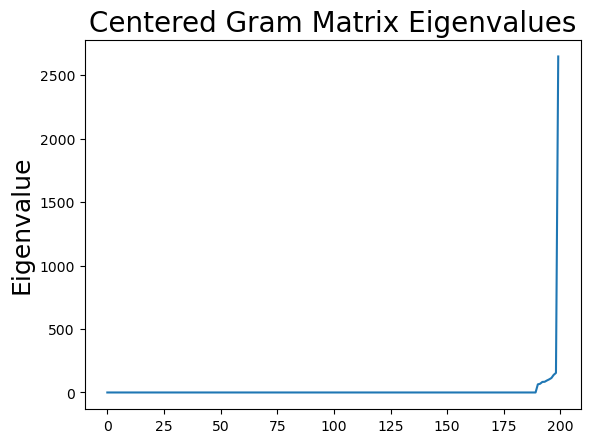

In [8]:
plt.plot(eigvals)
plt.title("Centered Gram Matrix Eigenvalues", fontsize=20)
plt.ylabel("Eigenvalue", fontsize=18)
plt.show()

There looks like there is one dominant eigenvalue that is much larger than the rest, so let's check this by listing the last 10 eigenvalues

In [9]:
eigvals[-10:]

array([  63.90562633,   68.83223558,   83.15650748,   84.20776741,
         94.4054168 ,  103.2455071 ,  114.06557614,  138.85013628,
        154.12900004, 2647.55462379])

Yes, there is clearly one dominant principal component - the last eigenvalue is so much larger than the rest. It accounts for 74.5% percent of the total variation between the matrices - can you remember how we calculate this percentage? For visual convenience we'll plot the scores for the first two principal components. First we'll need to calculate the scores. Remember from Chapter 3 that the score are the projections of the feature vectors (from each observation) onto each of the principal components. Chapter 3 tells us that the scores are given by using the eigenvector matrix to multiply a diagonal matrix formed from the singular values of the centered datamatrix in the new feature space. We can also get those singular values from the square root of the eigenvalues of the centered Gram matrix. So the eigendecomposition gives us all we need to calculate the PCA scores. 

In [10]:
# Calculate the scores from the eigenvector matrix and eigenvalues of the centered Gram matrix.
# One of the eigenvalues should be zero because we are dealing with an explicitly centered matrix.
# However, numerical precision may lead that zero eigenvalue to be slightly negative, but still very
# small in magnitude. All the other eigenvalues should be positive. Therefore, rather than taking the 
# square-root of the eigenvalues, we'll take the square-root of the absolute value of the eigenvalues.
scores = np.matmul(eigvecs, np.diag(np.sqrt(np.abs(eigvals))))

Now we can plot each matrix as a point in the score space. We'll use just the first two scores to do the plotting. Each point in the plot below corresponds to a single matrix plotted in a sort of 'PCA of matrices space'.

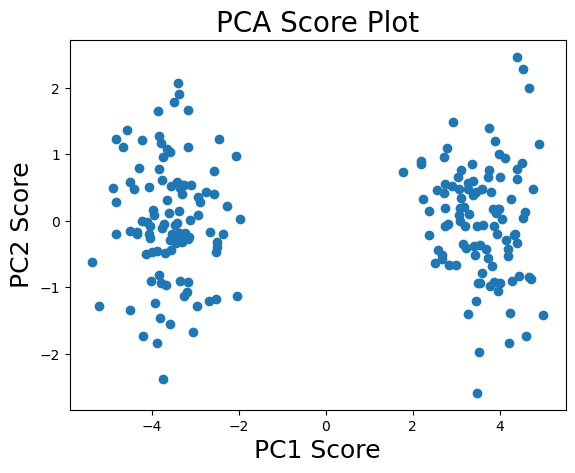

In [11]:
plt.scatter(x=scores[:, -1], y=scores[:, -2])
plt.title("PCA Score Plot", fontsize=20)
plt.xlabel("PC1 Score", fontsize=18)
plt.ylabel("PC2 Score", fontsize=18)
plt.show()

We can see that there are two distinct clusters of matrices, separated by the first principal component. This is what we should see - because that is how I created the data set. The variation of the scores along the second principal component shows essentially what is within-cluster variation.

Let's reflect on what we've just done. We've used a kernel function, combined with PCA, to reveal a hidden cluster structure in a dataset of matrices.